In [8]:
%pip install yfinance pandas_ta scikit-learn matplotlib statsmodels


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\sparsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:

import yfinance as yf
import statsmodels.api as sm

symbols = [
    "ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS", "AXISBANK.NS",
    "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "BPCL.NS", "BHARTIARTL.NS",
    "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS", "DRREDDY.NS",
    "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HDFCLIFE.NS",
    "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "ITC.NS",
    "INDUSINDBK.NS", "INFY.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LTIM.NS",
    "LT.NS", "M&M.NS", "MARUTI.NS", "NTPC.NS", "NESTLEIND.NS",
    "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBILIFE.NS", "SBIN.NS",
    "SUNPHARMA.NS", "TCS.NS", "TATACONSUM.NS", "TATAMOTORS.NS", "TATASTEEL.NS",
    "TECHM.NS", "TITAN.NS", "UPL.NS", "ULTRACEMCO.NS", "WIPRO.NS"
]


df = yf.download(symbols, start="2000-01-01")['Close'].dropna()

# df = yf.download(symbols, interval="1m", period="7d")['Close'].dropna()

print(df.head())

[*********************100%***********************]  50 of 50 completed

Ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
Date                                                                   
2017-11-17    83.979095     384.685028    1029.646240    1109.959961   
2017-11-20    86.016907     382.430389    1034.282837    1105.269043   
2017-11-21    82.289841     384.541138    1081.331055    1099.536011   
2017-11-22    84.622612     397.685364    1122.034546    1112.802856   
2017-11-23    81.780403     390.585571    1112.322632    1098.872192   

Ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
Date                                                                   
2017-11-17   539.377075    2637.366211     511.470154    1751.500610   
2017-11-20   542.111877    2666.274170     515.837280    1769.041626   
2017-11-21   543.752563    2714.179932     519.092712    1773.451416   
2017-11-22   537.487671    2724.830322     516.116516    1738.369507   
2017-11-23   541.117371    2684.901611     511.854034    1728.2

In [19]:
# Filtering out correlated stocks.

filtered_pairs = []
corr_matrix = df.corr()
corr_threshold = 0.8

for i in range(len(symbols)):
  for j in range(i + 1, len(symbols)):
    s1, s2 = symbols[i], symbols[j]
    corr = corr_matrix.loc[s1, s2]
    if corr > corr_threshold:
      filtered_pairs.append((s1, s2, corr))

# Sort by correlation
filtered_pairs.sort(key=lambda x: x[2], reverse=True)

# Output top correlated pairs
for s1, s2, corr in filtered_pairs:
  print(f"{s1} & {s2} → Corr: {corr}")

COALINDIA.NS & NTPC.NS → Corr: 0.9845337194221876
NTPC.NS & POWERGRID.NS → Corr: 0.983885161914043
POWERGRID.NS & SUNPHARMA.NS → Corr: 0.9801960008711811
INFY.NS & TCS.NS → Corr: 0.9763387767220079
BAJFINANCE.NS & BAJAJFINSV.NS → Corr: 0.9755579753615271
COALINDIA.NS & ONGC.NS → Corr: 0.9752921657880613
BHARTIARTL.NS & SUNPHARMA.NS → Corr: 0.9739429575047498
GRASIM.NS & ULTRACEMCO.NS → Corr: 0.9738458067704182
GRASIM.NS & HINDALCO.NS → Corr: 0.9737534929630344
BAJAJ-AUTO.NS & NTPC.NS → Corr: 0.973571544125237
APOLLOHOSP.NS & HCLTECH.NS → Corr: 0.9734752516505311
BAJAJ-AUTO.NS & POWERGRID.NS → Corr: 0.9728730263758367
HCLTECH.NS & ULTRACEMCO.NS → Corr: 0.972276734221652
APOLLOHOSP.NS & ICICIBANK.NS → Corr: 0.9711513036204176
ICICIBANK.NS & SBIN.NS → Corr: 0.971023407547166
GRASIM.NS & SBIN.NS → Corr: 0.9709253346252811
INFY.NS & LTIM.NS → Corr: 0.9699292060671091
APOLLOHOSP.NS & JSWSTEEL.NS → Corr: 0.9683534021357081
APOLLOHOSP.NS & TITAN.NS → Corr: 0.9683344525567429
LT.NS & NTPC.NS → 

In [20]:
# Filtering the co-integrated stocks

import pandas as pd
from statsmodels.tsa.stattools import coint

# Taking only 20 highest correlated stocks
# We can change it according to our needs.
filtered_pairs = filtered_pairs[:50]

co_integrated_pairs = []

for stock1, stock2, _ in filtered_pairs:
  prices1 = df[stock1].dropna()
  prices2 = df[stock2].dropna()
  
  # Align on common dates
  combined = pd.concat([prices1, prices2], axis=1).dropna()
  prices1_aligned = combined.iloc[:, 0]
  prices2_aligned = combined.iloc[:, 1]
  
  # Run cointegration test
  _, p_coint, _ = coint(prices1_aligned, prices2_aligned)
  if p_coint < 0.05:
    co_integrated_pairs.append((stock1, stock2, round(p_coint, 4)))

# Sorting by strongest co-integration
co_integrated_pairs.sort(key=lambda x: x[2])

for s1, s2, p in co_integrated_pairs:
  print(f"{s1} & {s2} → Cointegration p-value: {p}")

  


GRASIM.NS & HINDALCO.NS → Cointegration p-value: 0.0003
HCLTECH.NS & ULTRACEMCO.NS → Cointegration p-value: 0.003
ADANIPORTS.NS & CIPLA.NS → Cointegration p-value: 0.0036
RELIANCE.NS & TATACONSUM.NS → Cointegration p-value: 0.0037
BAJAJ-AUTO.NS & POWERGRID.NS → Cointegration p-value: 0.0083
EICHERMOT.NS & M&M.NS → Cointegration p-value: 0.0084
APOLLOHOSP.NS & ULTRACEMCO.NS → Cointegration p-value: 0.0089
CIPLA.NS & HCLTECH.NS → Cointegration p-value: 0.0092
APOLLOHOSP.NS & JSWSTEEL.NS → Cointegration p-value: 0.0108
ICICIBANK.NS & SBILIFE.NS → Cointegration p-value: 0.0184
NTPC.NS & POWERGRID.NS → Cointegration p-value: 0.021
COALINDIA.NS & ONGC.NS → Cointegration p-value: 0.0232
INFY.NS & TCS.NS → Cointegration p-value: 0.0239
POWERGRID.NS & SUNPHARMA.NS → Cointegration p-value: 0.0251
HINDALCO.NS & JSWSTEEL.NS → Cointegration p-value: 0.028
SBIN.NS & TATASTEEL.NS → Cointegration p-value: 0.0324
APOLLOHOSP.NS & TITAN.NS → Cointegration p-value: 0.0383
SBIN.NS & ULTRACEMCO.NS → Cointeg

In [21]:
print(co_integrated_pairs)

[('GRASIM.NS', 'HINDALCO.NS', 0.0003), ('HCLTECH.NS', 'ULTRACEMCO.NS', 0.003), ('ADANIPORTS.NS', 'CIPLA.NS', 0.0036), ('RELIANCE.NS', 'TATACONSUM.NS', 0.0037), ('BAJAJ-AUTO.NS', 'POWERGRID.NS', 0.0083), ('EICHERMOT.NS', 'M&M.NS', 0.0084), ('APOLLOHOSP.NS', 'ULTRACEMCO.NS', 0.0089), ('CIPLA.NS', 'HCLTECH.NS', 0.0092), ('APOLLOHOSP.NS', 'JSWSTEEL.NS', 0.0108), ('ICICIBANK.NS', 'SBILIFE.NS', 0.0184), ('NTPC.NS', 'POWERGRID.NS', 0.021), ('COALINDIA.NS', 'ONGC.NS', 0.0232), ('INFY.NS', 'TCS.NS', 0.0239), ('POWERGRID.NS', 'SUNPHARMA.NS', 0.0251), ('HINDALCO.NS', 'JSWSTEEL.NS', 0.028), ('SBIN.NS', 'TATASTEEL.NS', 0.0324), ('APOLLOHOSP.NS', 'TITAN.NS', 0.0383), ('SBIN.NS', 'ULTRACEMCO.NS', 0.0393), ('BAJAJ-AUTO.NS', 'NTPC.NS', 0.0411), ('SUNPHARMA.NS', 'ULTRACEMCO.NS', 0.0469), ('GRASIM.NS', 'SBIN.NS', 0.0479)]


In [22]:
"""
# Before moving to another step of using OLS to find beta. It is important to identify the dependent and independent stock.

Say you are analyzing:
- Stock A: ICICIBANK (stable, large-cap, low volatility)
- Stock B: HDFCBANK (more volatile)

Wrong Way:
-----------
- ICICIBANK = alpha + beta * HDFCBANK
- You're trying to model how the stable stock depends on the noisy one.

This gives:
- Poor beta
- Non-stationary spread
- Bad trading signals

Right Way:
-----------
- HDFCBANK = alpha + beta * ICICIBANK
- You're modeling how the noisier stock reacts to the stable one.

This gives:
- Accurate hedge ratio (β)
- Clean, mean-reverting spread
- Reliable entry/exit signals
"""

from statsmodels.tsa.stattools import adfuller, kpss

tradable_pairs = []

for stockOne, stockTwo, _ in co_integrated_pairs:

  dependentStock = None
  independentStock = None

  dailyReturns = df.pct_change().dropna()
  volatilityStockOne = dailyReturns[stockOne].std()
  volatilityStockTwo = dailyReturns[stockTwo].std()
  
  if volatilityStockOne > volatilityStockTwo:
    dependentStock = stockOne
    independentStock = stockTwo
  else:
    dependentStock = stockTwo
    independentStock = stockOne
  
  X = sm.add_constant(df[independentStock])
  model = sm.OLS(df[dependentStock], X).fit()
  beta = model.params[independentStock]
  
  spread = df[dependentStock] - beta * df[independentStock]

  adf_p_value = adfuller(spread)[1]
  kpss_p_value = kpss(spread, regression='c')[1]
  
  print(f'Dependent Stock = {dependentStock}, Independent Stock = {independentStock}, Beta = {beta}, ADF p-value = {adf_p_value}, KPSS p-value = {kpss_p_value}')

  if adf_p_value < 0.05 and kpss_p_value > 0.05:
    tradable_pairs.append((dependentStock, independentStock))
    
print(tradable_pairs)


Dependent Stock = HINDALCO.NS, Independent Stock = GRASIM.NS, Beta = 0.26357505946815585, ADF p-value = 2.0813034632577363e-05, KPSS p-value = 0.02611070703888666


C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = ULTRACEMCO.NS, Independent Stock = HCLTECH.NS, Beta = 5.796333814290766, ADF p-value = 0.0008010433206922197, KPSS p-value = 0.1


C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = ADANIPORTS.NS, Independent Stock = CIPLA.NS, Beta = 0.949718718902253, ADF p-value = 0.0006610291595429681, KPSS p-value = 0.1
Dependent Stock = TATACONSUM.NS, Independent Stock = RELIANCE.NS, Beta = 0.9076762254075943, ADF p-value = 0.0013727657424352762, KPSS p-value = 0.011160531971343823
Dependent Stock = BAJAJ-AUTO.NS, Independent Stock = POWERGRID.NS, Beta = 29.320737557129302, ADF p-value = 0.0016844706056839472, KPSS p-value = 0.013430542024498147
Dependent Stock = M&M.NS, Independent Stock = EICHERMOT.NS, Beta = 0.707519115412917, ADF p-value = 0.001780326317947955, KPSS p-value = 0.04649632847740409


C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = APOLLOHOSP.NS, Independent Stock = ULTRACEMCO.NS, Beta = 0.7652228655652251, ADF p-value = 0.001804578073056495, KPSS p-value = 0.01


C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = HCLTECH.NS, Independent Stock = CIPLA.NS, Beta = 1.1840447245045007, ADF p-value = 0.001183421490462249, KPSS p-value = 0.1
Dependent Stock = JSWSTEEL.NS, Independent Stock = APOLLOHOSP.NS, Beta = 0.12708997355398116, ADF p-value = 0.002118060397172393, KPSS p-value = 0.1
Dependent Stock = ICICIBANK.NS, Independent Stock = SBILIFE.NS, Beta = 0.9434550547713918, ADF p-value = 0.004142799001733539, KPSS p-value = 0.025704424641198577


C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = NTPC.NS, Independent Stock = POWERGRID.NS, Beta = 1.223340238922, ADF p-value = 0.004771439705390115, KPSS p-value = 0.01


C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = ONGC.NS, Independent Stock = COALINDIA.NS, Beta = 0.5401717188524682, ADF p-value = 0.004624278295655743, KPSS p-value = 0.1
Dependent Stock = INFY.NS, Independent Stock = TCS.NS, Beta = 0.5076489882008282, ADF p-value = 0.005601553084697652, KPSS p-value = 0.04272838091754702
Dependent Stock = SUNPHARMA.NS, Independent Stock = POWERGRID.NS, Beta = 5.381194642789971, ADF p-value = 0.007336707108724953, KPSS p-value = 0.02912975951782718


C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = HINDALCO.NS, Independent Stock = JSWSTEEL.NS, Beta = 0.6217517637331658, ADF p-value = 0.006746013363466956, KPSS p-value = 0.1
Dependent Stock = TATASTEEL.NS, Independent Stock = SBIN.NS, Beta = 0.24913893581292715, ADF p-value = 0.006730394114410291, KPSS p-value = 0.03791587145254835
Dependent Stock = APOLLOHOSP.NS, Independent Stock = TITAN.NS, Beta = 1.9988778530972353, ADF p-value = 0.009759826314113783, KPSS p-value = 0.04426936075877966
Dependent Stock = SBIN.NS, Independent Stock = ULTRACEMCO.NS, Beta = 0.07442816889307485, ADF p-value = 0.010048288390592677, KPSS p-value = 0.04052363453321569
Dependent Stock = NTPC.NS, Independent Stock = BAJAJ-AUTO.NS, Beta = 0.04016539048783578, ADF p-value = 0.0179290592784449, KPSS p-value = 0.01


C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = SUNPHARMA.NS, Independent Stock = ULTRACEMCO.NS, Beta = 0.16558722043304439, ADF p-value = 0.012402131532691457, KPSS p-value = 0.021605282907248936
Dependent Stock = SBIN.NS, Independent Stock = GRASIM.NS, Beta = 0.30557298366905417, ADF p-value = 0.009411392104757936, KPSS p-value = 0.036127962343840275
[('ULTRACEMCO.NS', 'HCLTECH.NS'), ('ADANIPORTS.NS', 'CIPLA.NS'), ('HCLTECH.NS', 'CIPLA.NS'), ('JSWSTEEL.NS', 'APOLLOHOSP.NS'), ('ONGC.NS', 'COALINDIA.NS'), ('HINDALCO.NS', 'JSWSTEEL.NS')]


In [23]:
print(f'Tradable Pairs are {tradable_pairs}')


Tradable Pairs are [('ULTRACEMCO.NS', 'HCLTECH.NS'), ('ADANIPORTS.NS', 'CIPLA.NS'), ('HCLTECH.NS', 'CIPLA.NS'), ('JSWSTEEL.NS', 'APOLLOHOSP.NS'), ('ONGC.NS', 'COALINDIA.NS'), ('HINDALCO.NS', 'JSWSTEEL.NS')]



# ## You can use below code for individual co-integrated stocks


In [24]:
import statsmodels.api as sm

# Using OLS to find the value of beta


# Just replace these values with stock tickers only to test for individual pairs.
dependentStock = 'ULTRACEMCO.NS'
independentStock = 'HCLTECH.NS'


X = sm.add_constant(df[independentStock])
model = sm.OLS(df[dependentStock], X).fit()
beta = model.params[independentStock]
print(f'Beta = {beta}')


# Now as we already found beta, we have to find the spread which is given by
# spread = stockOne - beta * stockTwo

# We could also calculate the value of spread as stockOne - stockTwo but
# that would not be sufficient, because this works only if both have similar price scales and volatilities — which is rare.
# Using beta the spread is now a stationary series (ideally), suitable for statistical trading.
spread = df[dependentStock] - beta * df[independentStock]


Beta = 5.796333814290766


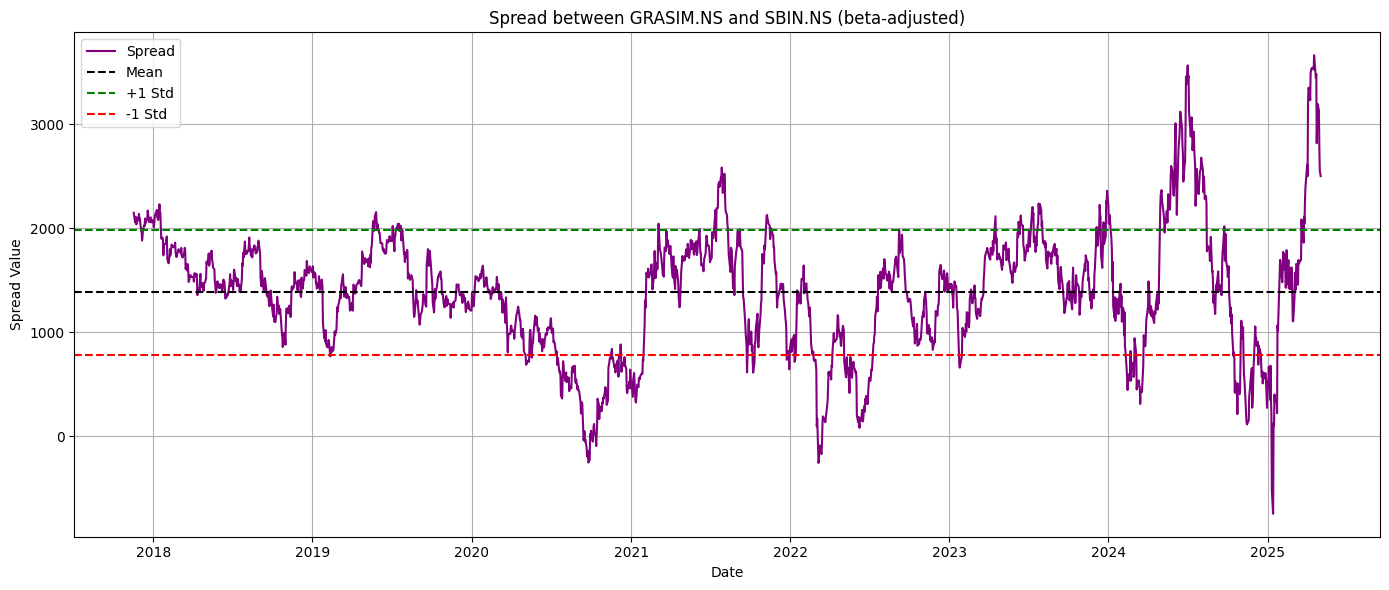

In [25]:


# Plotting the spread 
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(spread, label='Spread', color='purple', linewidth=1.5)
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.axhline(spread.mean() + spread.std(), color='green', linestyle='--', label='+1 Std')
plt.axhline(spread.mean() - spread.std(), color='red', linestyle='--', label='-1 Std')
plt.title(f'Spread between {stockOne} and {stockTwo} (beta-adjusted)')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [27]:


# Proceed with ADFS and KPSS tests

from statsmodels.tsa.stattools import adfuller, kpss

adf_p_value = adfuller(spread)[1]

kpss_p_value = kpss(spread, regression='c')[1]

print(f"ADF p-value: {adf_p_value}")
print(f"KPSS p-value: {kpss_p_value}")
if adf_p_value < 0.05 and kpss_p_value > 0.05:
  print("The spread is stationary. Proceed with trading.")
else:
  print("The spread is not stationary. Do not trade this pair.")



ADF p-value: 0.0008010433206922197
KPSS p-value: 0.1
The spread is stationary. Proceed with trading.


C:\Users\sparsh\AppData\Local\Temp\ipykernel_16968\3556811162.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
